In [167]:
import os
import codecs
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.precision', 10)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
#import plotly_express as px

#bokeh for plotting
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#for creating wordcloud
from wordcloud import WordCloud, STOPWORDS


from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from datetime import datetime

#import bert
#from bert import run_classifier
#from bert import optimization
#from bert import tokenization

import re
import spacy

#initiate spacy with english language
#nlp = spacy.load('en_core_web_sm')
import en_core_web_sm
nlp = en_core_web_sm.load()
from pattern.en import suggest
import nltk

#phrase modeling
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases , Phraser
import string
from nltk import pos_tag

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize
from gensim.models.word2vec import Text8Corpus
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim
from gensim import corpora

#LDA Topic Modeling
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings
import pickle

#dimensionality reduction - visualization
from sklearn.manifold import TSNE

#oversampling package
from imblearn.over_sampling import SMOTE

Loading BokehJS ...

In [482]:
#import the data
os.chdir('C:\\Users\\Sam Cannon\\Desktop\\MAAC\\NLP')
df = pd.read_csv('jackson_reviews.csv').iloc[2:, :].reset_index(drop = True)

#replace contractions with no apostrophe
df['reviews'] = df['reviews'].str.replace("doesn t", 'doesnt')
df['reviews'] = df['reviews'].str.replace("won t", 'wont')
df['reviews'] = df['reviews'].str.replace("haven t", 'havent')
df['reviews'] = df['reviews'].str.replace("don t", 'dont')
df['reviews'] = df['reviews'].str.replace("didn t", 'didnt')

df.head()

,Date,reviews,category,sentiment
0,7/3/2018,Front desk and check out staff are not nearly as nice as the professionals in the back Check out lady acts like she doesnt want to wait on you,front_office,negative
1,7/3/2018,Complete attention care More than expected,general,positive
2,7/3/2018,My doctor Dr Walcott was very professional and kind All the employees that took care of me were very professional and efficient,doctors,positive
3,7/3/2018,All is great,general,positive
4,7/3/2018,Dr Venarsky is outstanding as well as the staff I had an insurance question and Nicki was so helpful You guys are greatly appreciated,doctors_and_nurses,positive


In [483]:
#I think I am going to delete these reviews since there were only a few
df = df[df['sentiment'] != 'neutral']
df = df[df['sentiment'] != 'positive_and_negative'].reset_index(drop = True)

#convert labels to 1 = positive and 0 = negative (I misspelled positive and negative too during the labeling process, so I had to remedy that here)
df['sentiment'].replace(['positve', 'posiitve'], 'positive', inplace = True)
label_mapper = {'positive':1, 'negative':0}
Y = df['sentiment'].map(label_mapper)

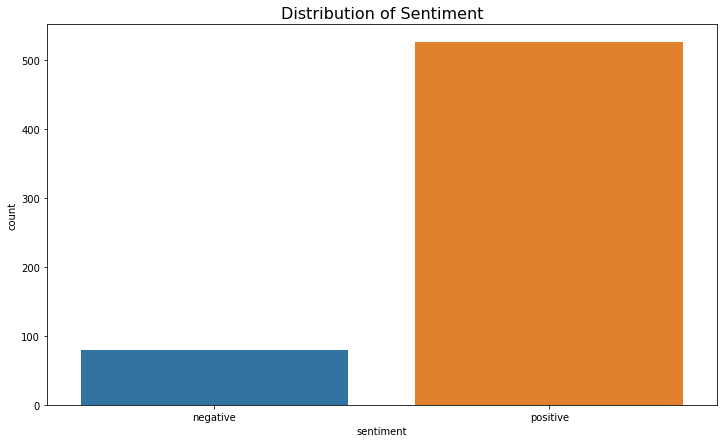

In [484]:
#looking at the distribution of sentiment, it appears as though we have a large class imbalance, 
# which I will deal with later by using SMOTE resampling
plt.figure(figsize = (12, 7))
sns.countplot(df['sentiment'])
plt.title('Distribution of Sentiment', fontsize = 16);

## Now I am going to begin phrase modeling and tokenizing the text

In [442]:
#get all reviews into list
data = list(df.reviews.values)

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

# Build the bigram and trigram models
#the min_count determines if the model ignores all words and bigrams with total collected count lower than this value.
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], min_count = 1, threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words - I am choosing to keep them in at this time
#data_words_nostops = remove_stopwords(data_words)

# Form trigrams - in this case we used the function to form bigrams for contracted words (i.e. 'front_desk'), it wasn't working with only bigrams
#data_words_trigrams = make_trigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words)


# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#or we can perform lemmatization, keeping more words, I chose to keep more words to add to the vocab size since some of them denote sentiment, in 
# my opinion
data_lemmatized = lemmatization(data_words_trigrams)

#take all of the lemmatized and trigrammed reviews and dump them into a new column
df['scrubbed_reviews'] = [x for x in data_lemmatized]

#convert column of lists to strings
df['scrubbed_reviews'] = df['scrubbed_reviews'].apply(', '.join)

#remove commas from strings
df['scrubbed_reviews'] = df['scrubbed_reviews'].str.replace(',','')

df.head()

,Date,reviews,category,sentiment,scrubbed_reviews
0,7/3/2018,Front desk and check out staff are not nearly as nice as the professionals in the back Check out lady acts like she doesnt want to wait on you,front_office,negative,front_desk check_out staff nearly as nice professional lady act want wait
1,7/3/2018,Complete attention care More than expected,general,positive,complete attention care expect
2,7/3/2018,My doctor Dr Walcott was very professional and kind All the employees that took care of me were very professional and efficient,doctors,positive,doctor very professional kind employee take care very professional efficient
3,7/3/2018,All is great,general,positive,great
4,7/3/2018,Dr Venarsky is outstanding as well as the staff I had an insurance question and Nicki was so helpful You guys are greatly appreciated,doctors_and_nurses,positive,outstanding as well staff insurance question so helpful guy greatly_appreciate


In [443]:
#this is one way to map words to ints, but it starts at 0 and we need to pad with 0s, so I had to use 
# another method
# # Create Dictionary
# id2word = corpora.Dictionary(data_lemmatized)

# # Create Corpus
# texts = data_lemmatized

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

In [446]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 2000

#I took out the underscore (_) from the filter due to wanting to keep tokens that were combined (i.e. front_desk)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~', lower=True)
tokenizer.fit_on_texts(df['scrubbed_reviews'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1344 unique tokens.


In [447]:
#what is the longest review?
lengths = []
for length in X_tokens:
    lengths.append(len(length))
max_loc = pd.DataFrame(lengths).idxmax()
pd.DataFrame(lengths).iloc[max_loc, :]

,0
515,143


In [448]:
#tokenize and pad sequences - choosing max length based on longest review, you can play around with this though if you only
# have a couple of reviews that are longer than the others, this is not the typical length, I could 
# reduce this if I wanted to 
MAX_SEQUENCE_LENGTH = 143
X_tokens = tokenizer.texts_to_sequences(df['scrubbed_reviews'].values)
X = keras.preprocessing.sequence.pad_sequences(X_tokens, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (605, 143)


In [486]:
#train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(544, 143) (544,)
(61, 143) (61,)


In [487]:
#oversample negative reviews using SMOTE
temp_df = pd.concat([pd.DataFrame(X), Y], axis = 1)

#instantiate SMOTE
smoter = SMOTE()

#fit SMOTE and transform/resample the training data only, DO NOT RESAMPLE THE TEST DATA IT WILL LEAD TO DATA LEAKAGE 
X_train, Y_train = smoter.fit_resample(X_train, Y_train)

#check the value counts to see if SMOTE worked
Y_train.value_counts()

1    471
0    471
Name: sentiment, dtype: int64

In [488]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.core import Dense, SpatialDropout1D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
from keras import backend as K

#create dimensions for the embedding layer
EMBEDDING_DIM = 100

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 2000

#since they cut out these metrics from tensorflow 2.0, we have to define them ourselves, but be careful since the network is evaluated in batches, # these metrics should be interpreted as such, not as the overall correct metric
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


#create sequential model, try out a CNN1D next
model = Sequential()

#add in an embedding layer, this takes all of our text tokens and creates 100-D embeddings for them
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))

#add in a sequential dropout layer for regularization - from tensorflow documentation:
# "This version performs the same function as Dropout, however it drops entire 1D feature maps instead of individual elements. If adjacent frames within feature maps are strongly correlated (as is normally the case in early convolution layers) then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease. In this case, SpatialDropout1D will help promote independence between feature maps and should be used instead."
model.add(SpatialDropout1D(0.2))

#create the LSTM layer
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

#create a Dense layer that will output one number (probability in this case), using the sigmoid function as the activation function
model.add(Dense(1, activation='sigmoid'))

#compile the model using binary crossentropy as our loss function, adam as the optimizer, and a multitude of metrics 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])

#specify epochs and batch size (you can play with these)
epochs = 5
batch_size = 64

#you can use the early stopping procedures here as well
# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', #patience=3, min_delta=0.0001)])
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 847 samples, validate on 95 samples
Epoch 1/5
847/847 [==============================] - 8s 9ms/step - loss: 0.6537 - accuracy: 0.5679 - f1_m: 0.7145 - precision_m: 0.5666 - recall_m: 0.9779 - val_loss: 0.8615 - val_accuracy: 0.2526 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/5
847/847 [==============================] - 5s 6ms/step - loss: 0.5909 - accuracy: 0.6954 - f1_m: 0.7532 - precision_m: 0.7147 - recall_m: 0.8085 - val_loss: 0.7551 - val_accuracy: 0.6526 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/5
847/847 [==============================] - 5s 6ms/step - loss: 0.5388 - accuracy: 0.7166 - f1_m: 0.7509 - precision_m: 0.7501 - recall_m: 0.7589 - val_loss: 0.6995 - val_accuracy: 0.6842 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/5
847/847 [==============================] - 6s 7ms/step - loss: 0.4651 - accuracy: 0.7627 - f1_m: 0.7881 - precisio

In [517]:
#looks like the model is scoring around 85% on F1 score after resampling, actually pretty good
accr = model.evaluate(X_test,Y_test, verbose = 0)
pred_classes = model.predict_classes(X_test, verbose = 0)
pred_classes = pred_classes[:, 0]

#in order to get f1 score, I am going to use sklearn since tensorflow dumped this in 2.0
from sklearn.metrics import f1_score
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
print('')
print(f'Test set F1 Score: {f1_score(Y_test,pred_classes)}')

Test set
  Loss: 0.509
  Accuracy: 0.754

Test set F1 Score: 0.845360824742268


In [539]:
#seems like we have to be more specific with our negative reviews for the model to pick it up, maybe I can add in a bunch of negative reviews from 
# another dataset? or I can write fake negative reviews myself...
#negative_review = ['doctor was in a hurry, I left very disappointed, I will not come back']
positive_review = ['Dr Walcott is my Asthma doctor and has been for several years He and his staff are always very courteous and professional I highly recommend them to everyone']
negative_review = ['I waited forever, but nobody seemed to care. I wont come back here, the people were not nice to me and I felt unwelcome']
seq = tokenizer.texts_to_sequences(negative_review)
padded = keras.preprocessing.sequence.pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

#print out the predictions (below .5 = negative, above .5 = positive)
print('--prediction for negative review--')
print(pred)

print('')
print('--prediction for positive review--')
seq = tokenizer.texts_to_sequences(positive_review)
padded = keras.preprocessing.sequence.pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(pred)

--prediction for negative review--
[[0.41657817]]

--prediction for positive review--
[[0.7822351]]


In [522]:
#pickle the neural network for future use
pickle.dump(model, open('review_sentiment_RNN.pkl', 'wb'))

In [ ]:
#----------------Next
#use fasttext vectors, reduce to 10 by tsne, upsample on the fasttext vectors
# use 1 dimensional CNN layer
# use transfer learning, freeze last two layers, use this for classificaion
